In [1]:
include("../init-notebook.jl")

(section-globalapprox-integration)=
# Spectrally accurate integration

In {numref}`section-localapprox-integration` we derived methods of order 2, 4, and higher for numerical integration. They all use a formula

:::{math}
:label: globalquad
\int_{-1}^1 f(x)\, dx \approx \sum_{k=0}^n w_k f(t_k)
:::

for a collection of nodes $t_0,\ldots,t_n$ in $[-1,1]$ and weights $w_0,\ldots,w_n$. (Throughout this section we use $[-1,1]$ as the domain of the integral; for a general interval $[a,b]$, see [Exercise 4](problem-integration-integrateinterval).) The nodes and weights are independent of the integrand $f(x)$ and determine the implementation and properties of the formula.

```{index} convergence rate; spectral
```
The process for deriving a specific method was to interpolate the integrand, then integrate the interpolant. Piecewise linear interpolation at equally spaced nodes, for instance, produces the trapezoid formula. When the integrand is approximated by a spectrally accurate global function, the integration formulas are also spectrally accurate.

## Periodic functions

For a function periodic on $[-1,1]$, the most natural interpolant is the trigonometric polynomial {eq}`trigcardinalinterp`. However, from {eq}`trigcardinal` one finds that

:::{math}
:label: trapperiod
\int_{-1}^1 \sum_{k=-n}^n y_k\tau_k(x)\, dx =  \sum_{k=-n}^n y_k\left[ \int_{-1}^1 \tau_k(x)\, dx\right] = \frac{2}{2n+1} \sum_{k=-n}^n y_k.
:::

```{index} trapezoid formula; for integration
```

In [Exercise 1](problem-specint-trapperiod) you are asked to verify that this result is identical to the value of the trapezoid formula on $2n+1$ nodes. 

```{proof:observation}
The trapezoid integration formula is spectrally accurate for periodic functions.
```

(demo-integration-ellipse)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We use the trapezoidal integration formula to compute the perimeter of an ellipse with semi-axes 1 and 1/2. Parameterizing the ellipse as $x=\cos \pi t$, $y=\frac{1}{2}\sin \pi t$ leads to the arc-length integral 

$$\int_{-1}^1 \pi\sqrt{ \cos^2(\pi t) + \tfrac{1}{4}\sin^2(\pi t)}\,dt.$$

In [2]:
f = t->π*sqrt( cos(π*t)^2+sin(π*t)^2/4 );

n = 4:4:48

for (i,n) in enumerate(n)
    h = 2/n
    t = @. h*(0:n-1)-1
    S = h*sum(f.(t))
   println("n = $n, value = $S")
end

n = 4, value = 4.71238898038469
n = 8, value = 4.839841556641369
n = 12, value = 4.843970706995739
n = 16, value = 4.844206195096973
n = 20, value = 4.8442227029563565
n = 24, value = 4.8442239922614245
n = 28, value = 4.844224099926928
n = 32, value = 4.844224109336828
n = 36, value = 4.844224110186873
n = 40, value = 4.8442241102656105
n = 44, value = 4.844224110273047
n = 48, value = 4.8442241102737595


The approximations gain about one digit of accuracy for each constant increment of $n$, which is consistent with spectral convergence.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Clenshaw–Curtis integration

Suppose $f$ is smooth but not periodic. If we use a global polynomial interpolating $f$ at the Chebyshev second-kind points from {eq}`chebextreme`,

$$
  %:label: chebextremerepeat
  t_k = - \cos\left(\frac{k \pi}{n}\right), \qquad k=0,\ldots,n,
$$

```{index} ! Clenshaw–Curtis integration
```
and integrate the resulting polynomial interpolant, the method should have spectral accuracy for a smooth integrand. The resulting algorithm is known as **Clenshaw–Curtis integration**.

Having specified the nodes in {eq}`globalquad`, all that remains is to find the weights. The Lagrange form of the interpolating polynomial is

$$
p(x) = \sum_{k=0}^{n} f(x_k) \ell_k(x).
$$

From this,

\begin{align*}
  I = \int_{-1}^1 f(x)\, dx \approx \int_{-1}^1 p(x) \, d x &= \int_{-1}^1 \sum_{k=0}^n f(x_k) \ell_k(x) \, d x\\
    &= \sum_{k=0}^n f(x_k) \int_{-1}^1 \ell_k(x) \, d x = \sum_{k=0}^n w_k f(x_k), 
\end{align*}

where $w_k = \int_{-1}^1 \ell_k(x)\,dx.$ For even values of $n$ the result is

:::{math}
  :label: clencurtweights
  w_k =
\begin{cases}
\dfrac{1}{n^2-1}, & \text{$k=0$ or $k=n$},\\[3mm]
\dfrac{4}{n} \displaystyle \sum_{j=0}^{n/2} \frac{\cos ( 2 \pi j k / n)}{\gamma_j
(1-4 j^2) }, & k=1,\dots,n-1,
\end{cases}
  \quad
\gamma_j =
\begin{cases}
2, & j=0 \text{ or } n/2,\\
1, & j=1,2,\dots,n/2-1.
\end{cases}
:::

There are different formulas for odd values of $n$. Note that the weights also depend on $n$; e. g. $w_2$ for $n=4$ is not the same as $w_2$ for $n=10$. Also note that the interpolant itself never needs to be computed.

{numref}`Function {number} <function-ccint>` performs Clenshaw–Curtis integration for even values of $n$.[^clencurt]

[^clencurt]: This function is modeled after the function `clencurt.m` of {cite}`trefethenSpectralMethods2000`.

(function-ccint)=
````{proof:function} ccint
**Clenshaw–Curtis numerical integration**
```{code-block} julia1
:lineno-start: 1
"""
    ccint(f,n)

Perform Clenshaw-Curtis integration for the function `f` on `n`+1
nodes in [-1,1]. Returns the integral estimate and a vector of the 
nodes used. Note: `n` must be even.
"""
function ccint(f,n)
    @assert iseven(n) "Value of `n` must be an even integer."
    # Find Chebyshev extreme nodes.
    θ = [ i*π/n for i in 0:n ]
    x = -cos.(θ)

    # Compute the C-C weights.
    c = similar(θ)
    c[[1,n+1]] .= 1/(n^2-1)
    s = sum( cos.(2k*θ[2:n])/(4k^2-1) for k in 1:n/2-1 )
    v = @. 1 - 2s - cos(n*θ[2:n])/(n^2-1)
    c[2:n] = 2v/n

    # Evaluate integrand and integral.
    I = dot(c,f.(x))   # vector inner product
    return I,x
end
```
````

## Gauss–Legendre integration

Let us reconsider the generic numerical integration formula {eq}`globalquad`,

$$
\int_{-1}^1 f(x)\, dx \approx \sum_{k=1}^n w_k f(t_k) = Q_{n}[f],
$$

where $Q_n[f]$ stands for the application of the formula to function $f$. (We start the sum from $k=1$ instead of $k=0$ for notational convenience in what follows.) 

The interpolation approach spurred us to use Chebyshev nodes. But it's not clear that these are ideal nodes for the specific application of finding an integral. Instead, we can define formula as the integral of a polynomial interpolant, but with the weights and nodes chosen to satisfy an optimality criterion. As usual, we denote the set of all polynomials of degree at most $m$ by $\mathcal{P}_m$.

(definition-specint-degree)=
::::{proof:definition} Degree of an integration formula
The **degree** of integration formula $Q_n$ is the maximum value of $d$ such that 

$$
Q_n[p]= \int_{-1}^1 p(x)\, dx
$$

for all $p\in \mathcal{P}_d$.
::::

Since there are $n$ nodes and $n$ weights available to choose, it seems plausible to expect $m=2n-1$, and this intuition turns out to be correct. Hence the goal is now to find nodes $t_k$ and weights $w_k$ such that

:::{math}
:label: gqoptimality
\int_{-1}^1 p(x)\,dx = Q_{n}[p] = \sum_{k=1}^n w_k p(t_k), \qquad p \in \mathcal{P}_{2n-1}.
:::

```{index} ! Gaussian integration
```
If these conditions are satisfied, the resulting method is called **Gauss–Legendre integration** or simply **Gaussian integration**. Because the integration formula is linear, i.e., $Q_n[\alpha p + q] = \alpha Q_n[p] + Q_n[q]$, it is sufficient to show that $Q_n$ gets the exact value for the monomials $1,x,x^2,\ldots,x^{2n-1}.$

(example-gquad2)=
::::{proof:example}
As an example, consider the case $n=2$. Applying the integration formula to each monomial of degree less than $2n$, we get the conditions
  
:::{math}
:label: gausscond2
\begin{split}
2 &= w_1 + w_2\\
0 &= w_1 t_1 + w_2 t_2 \\
\frac{2}{3} &= w_1 t_1^2 + w_2 t_2^2\\
0 &= w_1 t_1^3 + w_2 t_2^3.
\end{split}
:::

These equations can be solved to obtain

$$
w_1=w_2=1, \quad t_1 = -\frac{1}{\sqrt{3}}, \quad t_2 =
\frac{1}{\sqrt{3}},
$$

which specifies the two-point Gaussian integration formula.
::::

Generalizing the process above to general $n$ would be daunting, as the conditions on the nodes and weights are nonlinear. Fortunately, a more elegant approach is possible.

(theorem-specint-gaussquad)=
::::{proof:theorem}
The roots of the Legendre polynomial $P_n(x)$ are the nodes of an $n$-point Gaussian integration formula.
::::

::::{proof:proof}
Choose an arbitrary $p\in\mathcal{P}_{2n-1}$, and let $\hat{p}_n(x)$ be the lowest-degree interpolating polynomial for $p$ using the as-yet unknown nodes $t_1,\dots,t_n$. By definition,
 
$$
Q_n[p] = \int_{-1}^1 \hat{p}_n(x)\, dx.
$$
  
Since $\hat{p}_n(x)$ has degree at most $n-1$, it is exactly equal to $p$ if $p\in\mathcal{P}_{n-1}$, and {eq}`gqoptimality` is trivially satisfied. Otherwise, the error formula {eq}`interperror` implies

$$
p(x) - \hat{p}_n(x) = \frac{p^{(n)}(\xi(x))}{n!} \Phi(x),
$$

where $\Phi$ is the error indicator function $\prod_k (t-t_k).$ Trivially, the left-hand side is a polynomial in $\mathcal{P}_{2n-1}$ of degree at least $n$, so the right-hand side must be too. Thus, we can  write

$$
p(x) - \hat{p}_n(x) = \Psi(x) \Phi(x),
$$

where $\Psi(x)\in \mathcal{P}_{n-1}$ is unknown. The optimality requirement {eq}`gqoptimality` becomes

$$
0 = \int_{-1}^1 p(x)\,dx - Q_{n}[p]  = \int_{-1}^1 \bigl[p(x) - \hat{p}_n(x)\bigr]\,dx = \int_{-1}^1 \Psi(x) \Phi(x) \, dx.
$$

Given that $\Psi(x)\in \mathcal{P}_{n-1}$, we can ensure that this condition is satisfied if

:::{math}
:label: gqorthogonality
\int_{-1}^1 q(x)\Phi(x) \,dx = 0 
:::

for all $q \in {\mathcal{P}}_{n-1}$. Hence satisfaction of {eq}`gqorthogonality` implies satisfaction of {eq}`gqoptimality`. But by the orthogonality property of Legendre polynomials, satisfaction of {eq}`gqorthogonality` is guaranteed if $\Phi(x)=cP_n(x)$ for a constant $c$. Thus $\Phi$ and $P_n$ have the same roots.
::::

From {numref}`Theorem %s <theorem-orthogonal-roots>` we know that the roots of $P_n$ are distinct and all within $(-1,1)$. (Indeed, it would be strange to have the integral of a function depend on some of its values outside the integration interval!)  While there is no explicit formula for the roots, there are fast algorithms to compute them and the integration weights on demand. {numref}`Function {number} <function-glint>` uses one of the oldest methods,  practical up to $n=100$ or so.

(function-glint)=
````{proof:function} glint
**Gauss–Legendre numerical integration**
```{code-block} julia1
:lineno-start: 1
"""
    glint(f,n)

Perform Gauss-Legendre integration for the function `f` on `n` nodes
in (-1,1). Returns the integral estimate and a vector of the nodes used.
"""
function glint(f,n)
    # Nodes and weights are found via a tridiagonal eigenvalue problem.
    β = @. 0.5/sqrt(1-(2*(1:n-1))^(-2))
    T = diagm(-1=>β,1=>β)
    λ,V = eigen(T)
    p = sortperm(λ)
    x = λ[p]               # nodes
    c = @. 2V[1,p]^2       # weights

    # Evaluate the integrand and compute the integral.
    I = dot(c,f.(x))      # vector inner product
    return I,x
end
```
````

## Convergence

Both Clenshaw–Curtis and Gauss–Legendre integration are spectrally accurate. The Clenshaw–Curtis method on $n+1$ points has degree $n$, whereas the Gauss–Legendre method with $n$ points has degree ${2n-1}$. For this reason, it is possible for Gauss–Legendre to converge at a rate that is "twice as fast," i.e., with roughly the square of the error of Clenshaw–Curtis. But the full story is not simple.

(demo-integration-compare)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

First consider the integral 

$$
\int_{-1}^1 \frac{1}{1+4x^2} \, dx = \arctan(2).
$$

In [3]:
f = x->1/(1+4*x^2);
exact = atan(2);

We compare the two spectral integration methods for a range of $n$ values.

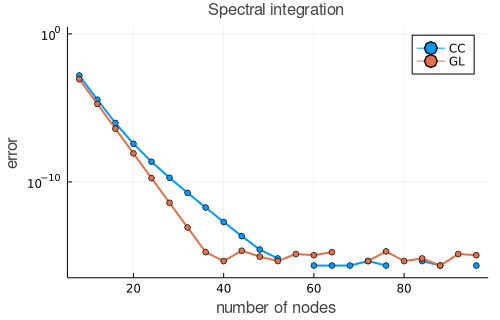

In [4]:
n = 8:4:96
errCC = zeros(size(n))
errGL = zeros(size(n))
for (k,n) in enumerate(n)
  errCC[k] = abs(exact - FNC.ccint(f,n)[1])
  errGL[k] = abs(exact - FNC.glint(f,n)[1])
end

errCC[iszero.(errCC)] .= NaN
errGL[iszero.(errGL)] .= NaN
plot(n,[errCC errGL],m=:o,label=["CC" "GL"],
    xaxis=("number of nodes"), yaxis=(:log10,"error",[1e-16,1]), 
    title="Spectral integration")

(The missing dots are where the error is exactly zero.) Gauss–Legendre does converge faster here, but at something less than twice the rate.

Now we try a more sharply peaked integrand:
 
 $$\int_{-1}^1 \frac{1}{1+16x^2} \, dx = \frac{1}{2}\arctan(4).$$

In [5]:
f = x->1/(1+16*x^2);
exact = atan(4)/2;

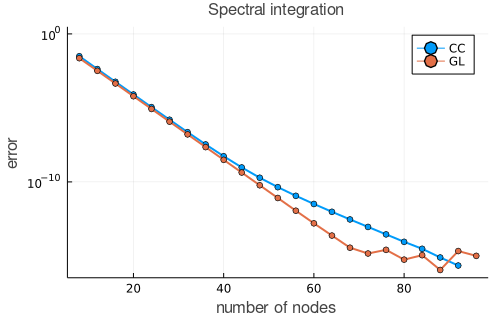

In [6]:
n = 8:4:96
errCC = zeros(size(n))
errGL = zeros(size(n))
for (k,n) in enumerate(n)
  errCC[k] = abs(exact - FNC.ccint(f,n)[1])
  errGL[k] = abs(exact - FNC.glint(f,n)[1])
end

errCC[iszero.(errCC)] .= NaN
errGL[iszero.(errGL)] .= NaN
plot(n,[errCC errGL],m=:o,label=["CC" "GL"],
    xaxis=("number of nodes"), yaxis=(:log10,"error",[1e-16,1]), 
    title="Spectral integration")

The two are very close until about $n=40$, when the Clenshaw–Curtis method slows down.

Now let's compare the spectral performance to that of our earlier adaptive method in `intadapt`. We will specify varying error tolerances and record the error as well as the total number of evaluations of $f$.

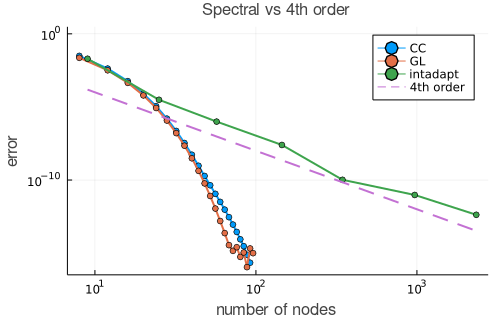

In [7]:
tol = 10 .^(-2.0:-2:-14)
n = zeros(size(tol))  
errAdapt = zeros(size(tol))
for (k,tol) in enumerate(tol)
  Q,t = FNC.intadapt(f,-1,1,tol)
  errAdapt[k] = abs(exact - Q)
  n[k] = length(t)
end

errAdapt[iszero.(errAdapt)] .= NaN
plot!(n,errAdapt,m=:o,label="intadapt")
plot!(n,n.^(-4),l=:dash,label="4th order",
        xaxis=(:log10), title="Spectral vs 4th order" )

At the core of `intadapt` is a fourth-order formula, and the results track that rate closely. For all but the most relaxed error tolerances, both spectral methods are far more efficient than the low-order counterpart. For other integrands, particularly those that vary nonuniformly across the interval, the adaptive method might be more competitive.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


The difference in convergence between Clenshaw–Curtis and Gauss–Legendre is dwarfed by the difference between spectral and algebraic convergence. It is possible, though, to encounter integrands for which adaptivity is critical.  Choosing a method is highly problem-dependent, but a rule of thumb is that for large error tolerances, an adaptive low-order method is likely to be a good choice, while for high accuracy, the spectral methods often dominate.

## Exercises

(problem-specint-trapperiod)=
1. ✍  Suppose $f$ is periodic on $[-1,1]$. Show that the result of applying the trapezoid formula on $2n+1$ points is identical to {eq}`trapperiod`.

2. ✍ For each integral, use Gauss–Legendre integration with $n=2$ to write out the terms $w_1f(t_1)$ and $w_2f(t_2)$ explicitly. 

    **(a)** $\displaystyle\int_{-1}^1 e^{-x}\, dx = 2 \sinh(1) \qquad$
    **(b)** $\displaystyle\int_{-1}^1 e^{-x^2} \qquad$
    **(c)** $\displaystyle\int_{-1}^1 (2+x)^{-1}$

    (problem-specint-ccglcompare)=
3. ⌨ For each integral, compute approximations using {numref}`Function {number} <function-ccint>` and {numref}`Function {number} <function-glint>` with $n=4,6,8,\ldots,40$. Plot the errors of both methods together as functions of $n$ on a semi-log scale. 

    **(a)** $\displaystyle\int_{-1}^1 e^{-4x}\, dx = \sinh(4)/2$

    **(b)** $\displaystyle\int_{-1}^1 e^{-9x^2} = \sqrt{\pi}\, \operatorname{erf}(3)/3$

    **(c)** $\displaystyle\int_{-1}^1 \operatorname{sech}(x) \, dx = 2 \tan^{-1} [ \sinh (1) ]$

    **(d)** $\displaystyle\int_{-1}^1 \frac{1}{1+9x^2}\, dx = \frac{2}{3} \tan^{-1}(3)$

    (problem-integration-integrateinterval)=
4. 
    **(a)** ✍ (See also [Exercise 9.3.5](problem-stability-changeinterval).) Using the change of variable 

    $$
    z = \phi(x) = a + (b-a)\frac{(x+1)}{2},
    $$

    show that 

    $$
    \int_{a}^b f(z) \, d z= \frac{b-a}{2} \int_{-1}^{1} f( \phi(x) ) \, d x .
    $$

    **(b)** ⌨ Rewrite {numref}`Function {number} <function-ccint>` and {numref}`Function {number} <function-glint>` to accept additional inputs for $a$ and $b$ and compute integrals over $[a,b]$.
    
    **(c)** ⌨  Repeat the steps of [Exercise 2](problem-specint-ccglcompare) for the integral

    $$
    \int_{\pi/2}^{\pi} x^2 \sin 8x \, d x = -\frac{3 \pi^2}{32}.
    $$

5. ⌨ A particle moves in a circular path with angular velocity given by $\omega(\theta)=\sin(\exp(\sin \theta))$. The time it takes to complete one full orbit is 

    $$
    T = \int_0^T dt = \int_{0}^{2\pi} \frac{d\theta}{d\theta / dt } = \int_{0}^{2\pi} \frac{d\theta}{\omega(\theta) }.
    $$

    Use {numref}`Function {number} <function-trapezoid>` to find the period of the motion. Show results for different values of $n$ to establish convergence to at least 12 digits.

6. ✍ Prove the claim about linearity of the Gauss–Legendre integration formula alluded to in the derivation of {numref}`Theorem %s <theorem-specint-gaussquad>`. Namely, show that condition {eq}`gqoptimality` is true if and only if

    $$
    \int_{-1}^1 x^j\,dx = \sum_{k=1}^n w_k x_k^j
    $$

    for all $j=0,\ldots,2n-1$.